In [1]:

# ✅ Breast Cancer Prediction Pipeline (Non-Image)
# Custom Model: BreastEnsembleNet‑V1 (Ensemble of Lightweight FCNN branches)
# Dataset: Breast Cancer Wisconsin (Diagnostic)

# 1. Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))




2025-07-26 13:16:50.329337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753535810.518550      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753535810.571033      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available: 1


In [2]:
# 2. Data Structures & 3. Load Dataset
path = "/kaggle/input/cancer/breast-cancer.csv"  # Replace with actual path

df = pd.read_csv(path)
print(df.head())



         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

Class Distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64


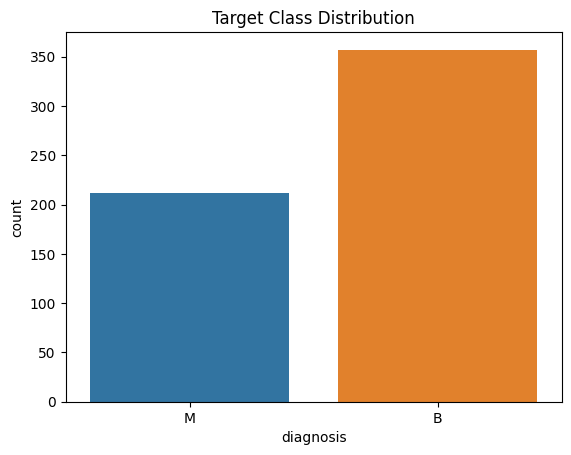

In [3]:
# 4. Show Distribution
print("Class Distribution:")
print(df['diagnosis'].value_counts())
sns.countplot(x='diagnosis', data=df)
plt.title("Target Class Distribution")
plt.show()



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

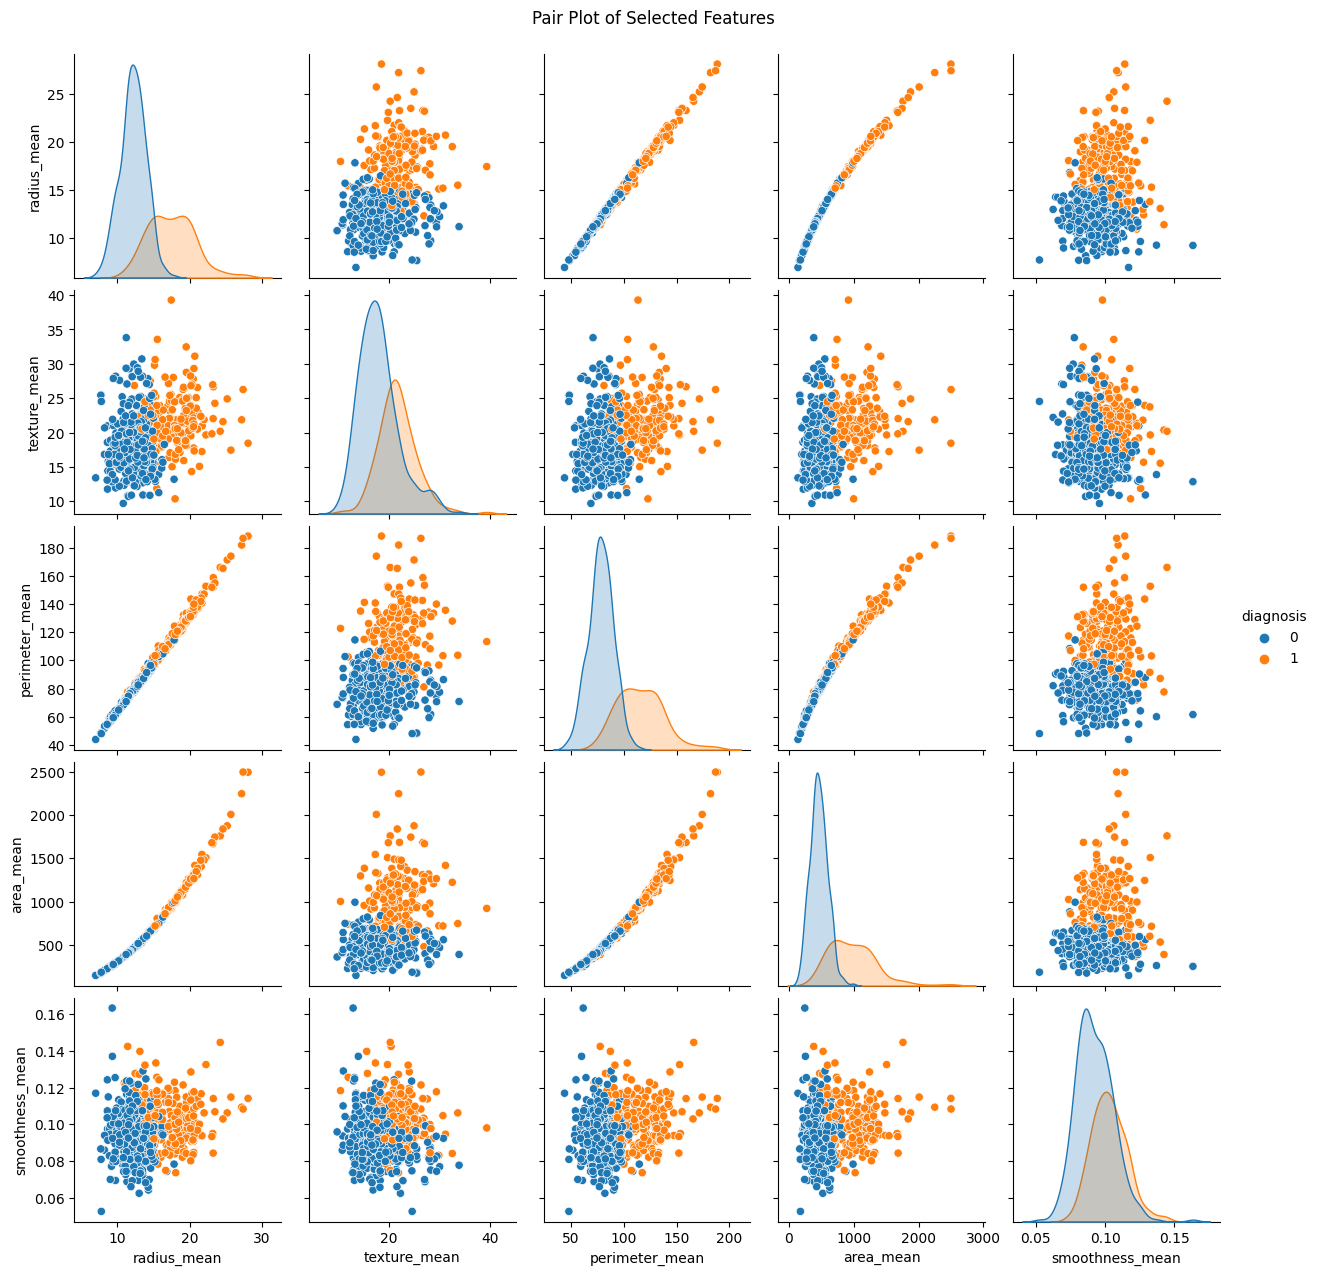

In [25]:
# ✅ Corrected Pair Plot Code
pairplot_df = df.iloc[:, :6].copy()
pairplot_df['diagnosis'] = df['diagnosis']
sns.pairplot(pairplot_df, hue='diagnosis')
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


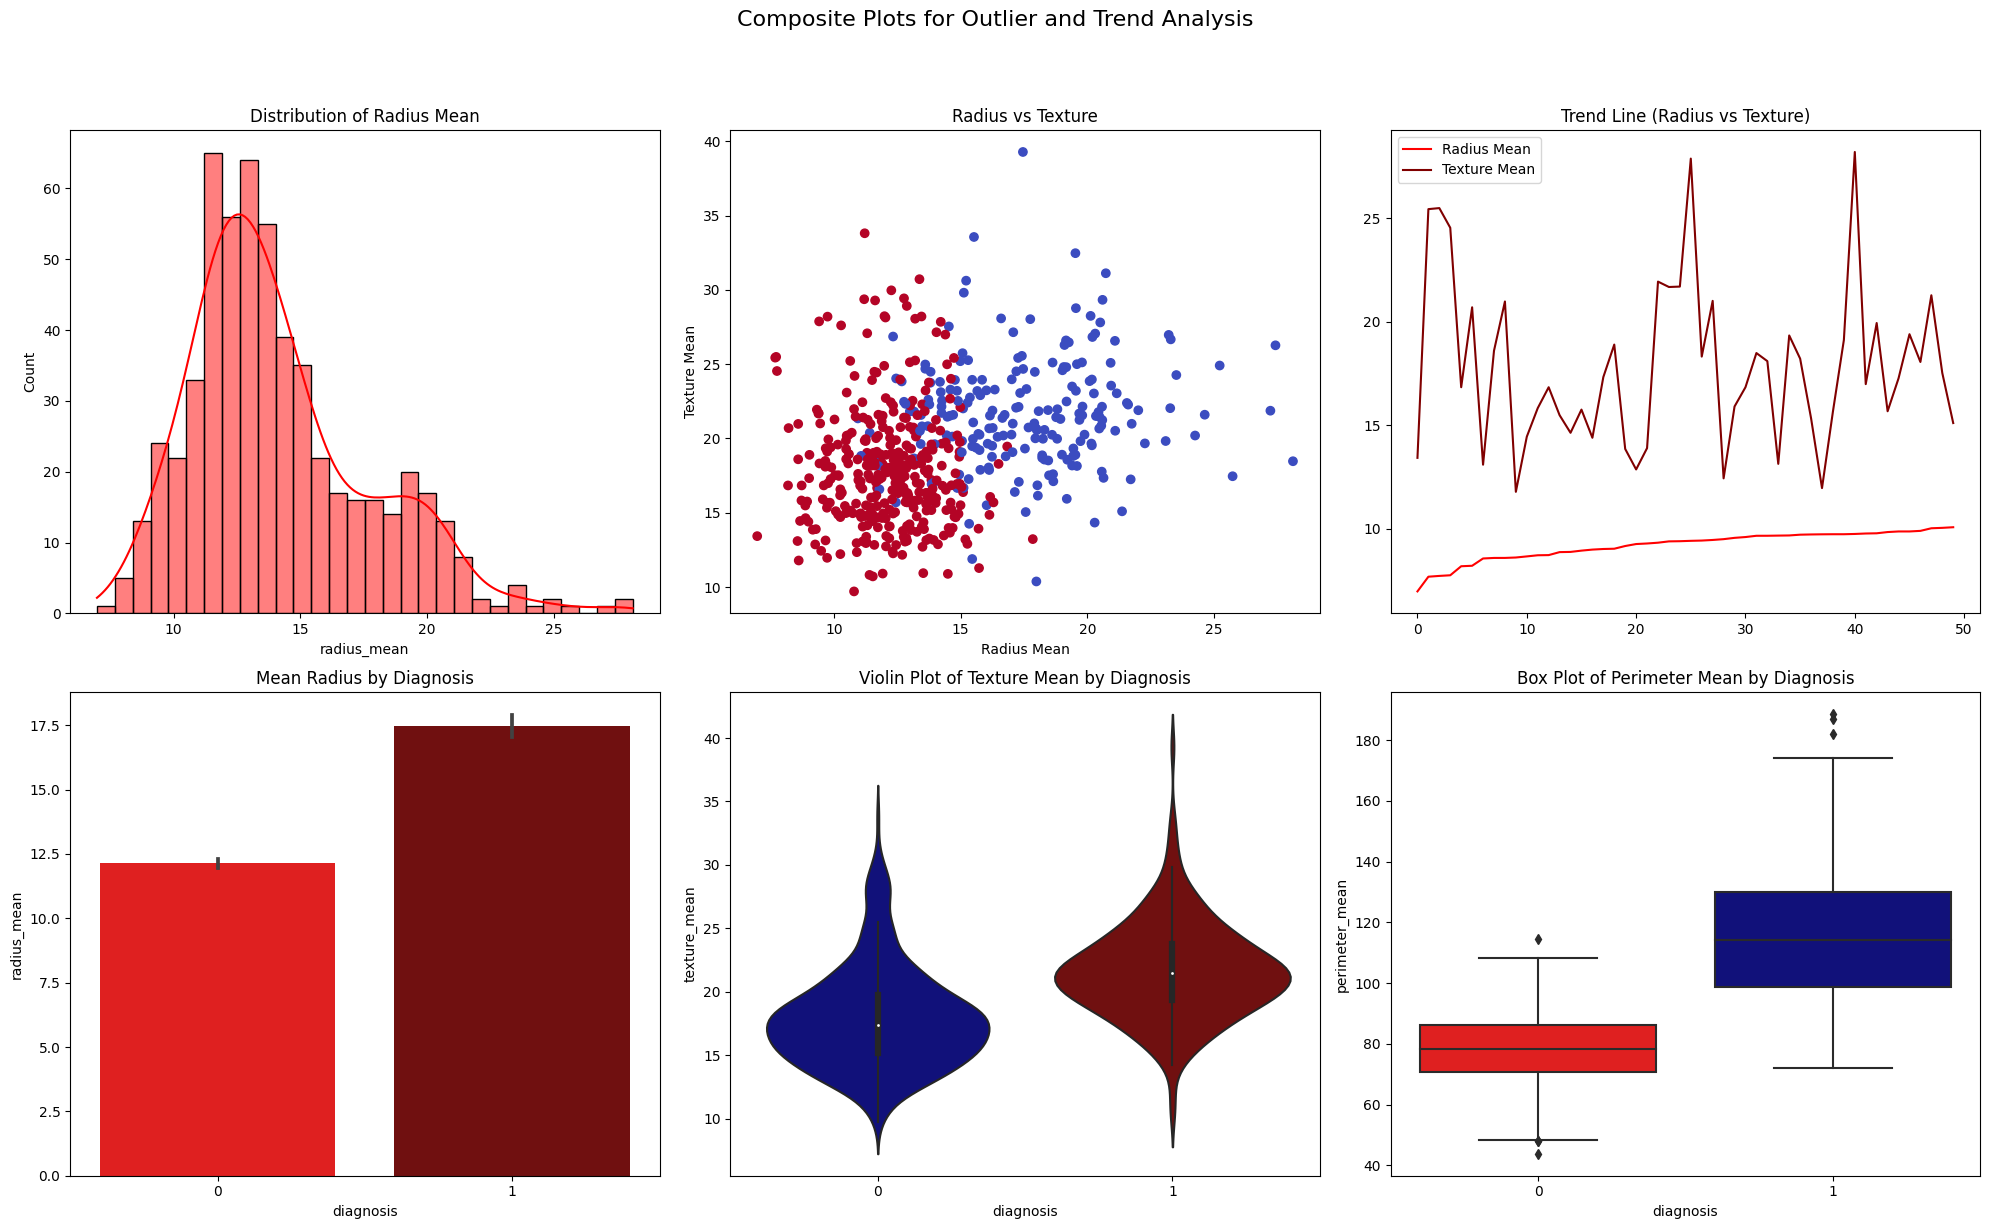

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ 3x2 Grid
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Composite Plots for Outlier and Trend Analysis", fontsize=16, y=1.02)

# ✅ Plot 1: Distribution Plot
sns.histplot(df['radius_mean'], bins=30, kde=True, ax=axes[0, 0], color='red')
axes[0, 0].set_title('Distribution of Radius Mean')

# ✅ Plot 2: Scatter Plot (Fixed cmap)
colors = pd.factorize(df['diagnosis'])[0]
scatter = axes[0, 1].scatter(df['radius_mean'], df['texture_mean'], c=colors, cmap='coolwarm')
axes[0, 1].set_title('Radius vs Texture')
axes[0, 1].set_xlabel('Radius Mean')
axes[0, 1].set_ylabel('Texture Mean')

# ✅ Plot 3: Line Plot
df_sorted = df.sort_values(by='radius_mean')
axes[0, 2].plot(df_sorted['radius_mean'].values[:50], label='Radius Mean', color='red')
axes[0, 2].plot(df_sorted['texture_mean'].values[:50], label='Texture Mean', color='maroon')
axes[0, 2].set_title('Trend Line (Radius vs Texture)')
axes[0, 2].legend()

# ✅ Plot 4: Categorical Bar Plot
sns.barplot(x="diagnosis", y="radius_mean", data=df, ax=axes[1, 0], palette=["red", "maroon"])
axes[1, 0].set_title("Mean Radius by Diagnosis")

# ✅ Plot 5: Violin Plot
sns.violinplot(x='diagnosis', y='texture_mean', data=df, ax=axes[1, 1], palette=['darkblue', 'maroon'])
axes[1, 1].set_title("Violin Plot of Texture Mean by Diagnosis")

# ✅ Plot 6: Box Plot
sns.boxplot(x='diagnosis', y='perimeter_mean', data=df, ax=axes[1, 2], palette=['red', 'darkblue'])
axes[1, 2].set_title("Box Plot of Perimeter Mean by Diagnosis")

# ✅ Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [12]:
# 5. Preprocessing
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# 6. Improved BreastEnsembleNet‑V1 Definition
def branch_fcnn(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    model = models.Model(inputs, x)
    return model

def BreastEnsembleNetV1(input_shape):
    input_layer = layers.Input(shape=input_shape)

    branch1 = branch_fcnn(input_shape)(input_layer)
    branch2 = branch_fcnn(input_shape)(input_layer)
    branch3 = branch_fcnn(input_shape)(input_layer)

    merged = layers.Concatenate()([branch1, branch2, branch3])
    x = layers.Dense(64, activation='relu')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_layer, outputs=output, name="BreastEnsembleNetV1")
    return model

# Build model
model = BreastEnsembleNetV1((X_train.shape[1],))


In [14]:
# 7. Model Summary
model.summary()



Model: "BreastEnsembleNetV1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 32)        │      4,448 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 32)        │      4,448 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 32)        │      4,448 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ functional_3[0][… │
│ (Concatenate)       │                   │            │ functional_4[0][… │
│                     │                   │            │ functional_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      6,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,873 (77.63 KB)

 Trainable params: 19,169 (74.88 KB)

 Non-trainable params: 704 (2.75 KB)

In [30]:
# ✅ Custom Callback for Early Stop on Accuracy ≥ 99%
class EarlyStopAtAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("val_accuracy")
        if acc is not None and acc >= 0.99:
            print(f"\nReached 99% val accuracy. Stopping training at epoch {epoch+1}.")
            self.model.stop_training = True

In [31]:
# 8. Fast Training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stop_acc = EarlyStopAtAccuracy()

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=16,
    callbacks=[lr_reduce, early_stop_acc],
    verbose=1
)


Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.9829 - loss: 0.2453 - val_accuracy: 0.9451 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9938 - loss: 0.1851 - val_accuracy: 0.9560 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9865 - loss: 0.1876 - val_accuracy: 0.9670 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9941 - loss: 0.1660 - val_accuracy: 0.9560 - val_loss: 0.2750 - learning_rate: 0.0010
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9775 - loss: 0.1999 - val_accuracy: 0.9560 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9899 - loss: 0.1827 - val_accuracy: 0.9670 - val_loss: 0.2692 - learning_rate: 0.0010
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9925 - loss: 0.1700 - val_

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


Test Accuracy: 97.37%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



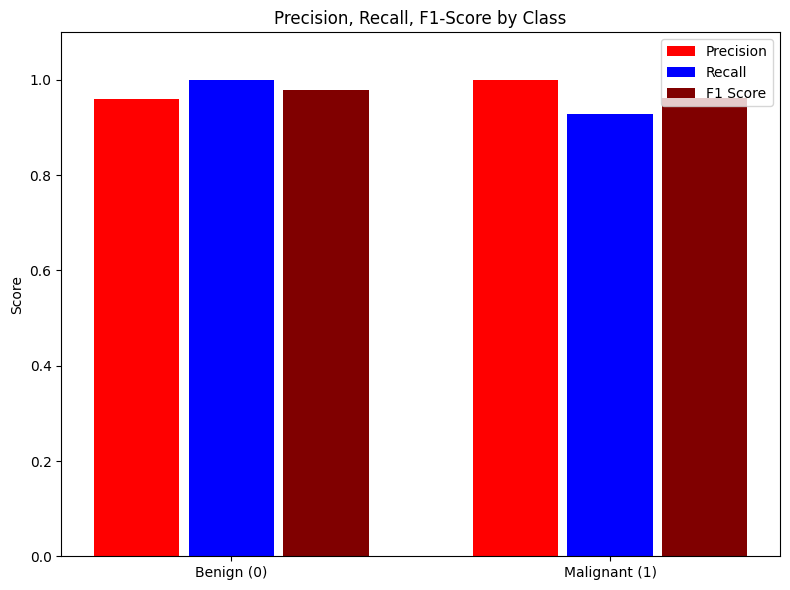

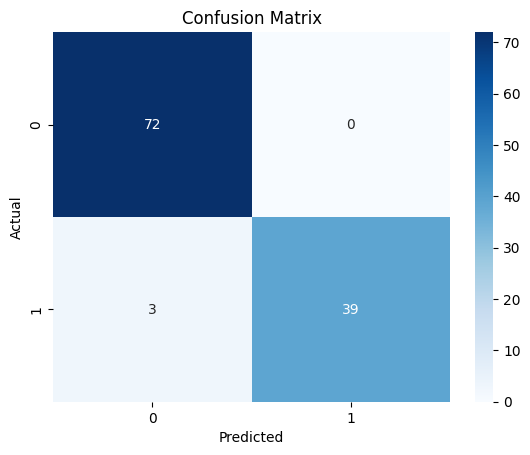

In [38]:
# 9. Evaluation
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc*100:.2f}%")

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

# Classification Visualization
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])
labels = ['Benign (0)', 'Malignant (1)']

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 6))
plt.bar(x - width, precision, width=width * 0.9, label='Precision', color='red')
plt.bar(x, recall, width=width * 0.9, label='Recall', color='blue')
plt.bar(x + width, f1, width=width * 0.9, label='F1 Score', color='maroon')

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score by Class")
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

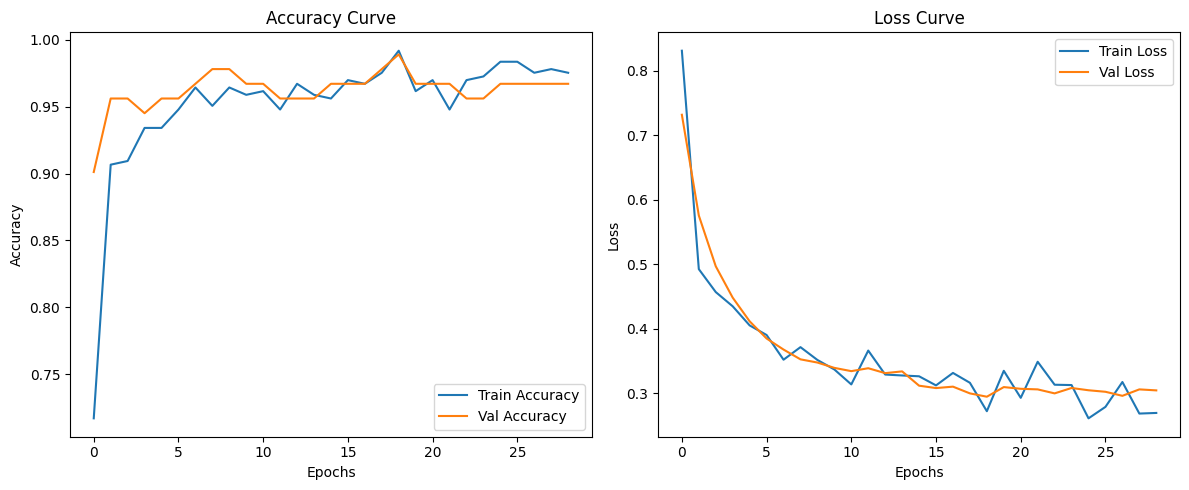

In [20]:
# 🔁 Learning Curves
plt.figure(figsize=(12, 5))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
